In [31]:
from lightgbm import LGBMRegressor
from hyperopt import fmin, tpe, space_eval, hp, Trials
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import cross_val_score
from prunedcv import PrunedCV
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
data = fetch_california_housing()
x = data['data']
y = data['target']

In [3]:
model = LGBMRegressor()

In [4]:
def objective_standard(params):
    
    for parameters in ['n_estimators', 'num_leaves', 'max_depth']:
        params[parameters] = int(params[parameters])
    
    model.set_params(**params)

    return - np.mean(cross_val_score(model, x, y, cv=12, scoring='neg_mean_squared_error'))

In [5]:
space = {
    'n_estimators': hp.quniform('n_estimators', 5, 100, 1),
    'num_leaves': hp.quniform('num_leaves', 2, 100, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'learning_rate': hp.uniform('learning_rate', 1e-4, 1e-0),
    'max_depth': hp.quniform('max_depth', 2, 1_000, 1)
}

In [6]:
bayes_trials_standard = Trials()
best_standard = fmin(fn=objective_standard, 
                     space=space, 
                     algo=tpe.suggest, 
                     max_evals=200, 
                     trials=bayes_trials_standard, 
                     rstate=np.random.RandomState(42))

100%|██████████| 200/200 [04:25<00:00,  1.17it/s, best loss: 0.33260919196403954]


For probabilistic search methods like Bayesian Optimization you should use probabilistic pruning:

In [7]:
prun = PrunedCV(12, probabilistic_prun=True)

def objective_pruned(params):

    for parameters in ['n_estimators', 'num_leaves', 'max_depth']:
        params[parameters] = int(params[parameters])
    
    model.set_params(**params)

    return prun.cross_val_score(model, x, y)

In [25]:
bayes_trials_pruned = Trials()
best_pruned = fmin(fn=objective_pruned, 
                   space=space, 
                   algo=tpe.suggest, 
                   max_evals=1_000, 
                   trials=bayes_trials_pruned, 
                   rstate=np.random.RandomState(42))

100%|██████████| 1000/1000 [04:06<00:00,  3.46it/s, best loss: 0.3292563469527635]


In [26]:
df_prun = []
for trial in bayes_trials_pruned.trials:
    df_prun.append([trial['result']['loss'], trial['refresh_time']])

df_prun = pd.DataFrame(df_prun, columns=['value', 'time_finished'])
df_prun['time'] = (df_prun.time_finished - df_prun.time_finished.min()).astype('int') / 1_000_000_000

df_stan = []
for trial in bayes_trials_standard.trials:
    df_stan.append([trial['result']['loss'], trial['refresh_time']])

df_stan = pd.DataFrame(df_stan, columns=['value', 'time_finished'])
df_stan['time'] = (df_stan.time_finished - df_stan.time_finished.min()).astype('int') / 1_000_000_000

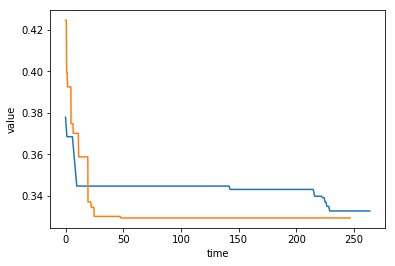

In [27]:
sns.lineplot(x=df_stan.time, y=df_stan.value.cummin());
sns.lineplot(x=df_prun.time, y=df_prun.value.cummin());

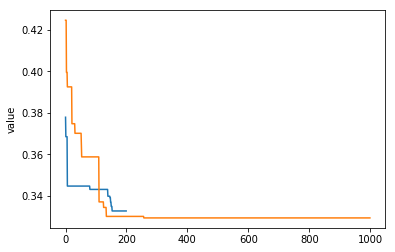

In [28]:
sns.lineplot(x=df_stan.index, y=df_stan.value.cummin());
sns.lineplot(x=df_prun.index, y=df_prun.value.cummin());

In [30]:
round((df_stan.time.max() / df_stan.shape[0]) / (df_prun.time.max() / df_prun.shape[0]),2)

5.35